In [3]:
!nvidia-smi

Wed Apr 12 13:31:49 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070         On | 00000000:01:00.0  On |                  N/A |
| 45%   50C    P8               29W / 220W|   2116MiB /  8192MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip3 install opencv-python scikit-learn
!apt-get -y install libgl1-mesa-glx

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


# import

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import regularizers
from keras import optimizers
from glob import glob
from tqdm import tqdm

# Preprocessing

In [5]:
dataset_path = "./dataset/img/img128/"

In [6]:
label_df = pd.read_csv('./dataset/original/trainLabels.csv')
label_df

,Id,Class
0,01kcPWA9K2BOxQeS5Rju,1
1,04EjIdbPV5e1XroFOpiN,1
2,05EeG39MTRrI6VY21DPd,1
3,05rJTUWYAKNegBk2wE8X,1
4,0AnoOZDNbPXIr2MRBSCJ,1
...,...,...
10863,KFrZ0Lop1WDGwUtkusCi,9
10864,kg24YRJTB8DNdKMXpwOH,9
10865,kG29BLiFYPgWtpb350sO,9
10866,kGITL4OJxYMWEQ1bKBiP,9


In [7]:
x = []
y = []

image_w = 128
image_h = 128

for idx, row in tqdm(label_df.iterrows()):
    img_path = f"./dataset/img/img128/{row['Id']}.png"
    malware_class = row['Class']
    
    img = cv2.imread(img_path)
    img = cv2.resize(img, None, 
                     fx=image_w/img.shape[1], 
                     fy=image_h/img.shape[0])
    img = img[:,:,0].reshape(image_w,image_h,1)
    
    x.append(img/255.)
    y.append(tf.keras.utils.to_categorical(malware_class-1,9))
    
x = np.array(x)
y = np.array(y)
    
train_img, val_img, train_label, val_label = train_test_split(x, 
                                                  y, 
                                                  stratify=y, 
                                                  test_size=0.2)

10868it [00:04, 2461.58it/s]


In [8]:
train_img.shape, val_img.shape, train_label.shape, val_label.shape

((8694, 128, 128, 1), (2174, 128, 128, 1), (8694, 9), (2174, 9))

# Dataset

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_img, train_label)).shuffle(buffer_size=100000).batch(256)
val_dataset = tf.data.Dataset.from_tensor_slices((val_img, val_label)).batch(256)

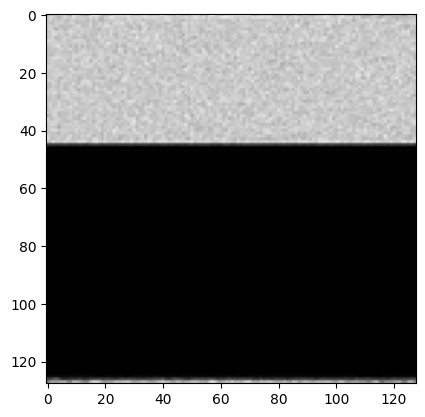

Label : [0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [10]:
img, label = next(iter(train_dataset))

plt.imshow(img[0], cmap='gray')
plt.show()

print(f"Label : {label[0]}")

# Simple CNN

In [18]:
def Simple_CNN():
    model = tf.keras.Sequential()
    model.add(Conv2D(50, (5,5), 
                             activation='relu', padding='same',
                             input_shape=(128, 128, 1)))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(70, (3,3), 
                             activation='relu', padding='same',
                             input_shape=(64, 64, 50)))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(70, (3,3), 
                             activation='relu', padding='same',
                             input_shape=(32, 32, 70)))
    model.add(MaxPooling2D((2,2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(9, activation='softmax'))
    
    adam = optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [19]:
malware_class = Simple_CNN()
malware_class.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 50)      1300      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 50)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 70)        31570     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 70)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 70)        44170     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 70)      

In [12]:
save_path = './model/malware_cnn32/'
checkpoint_path = save_path+"/model_{epoch}.ckpt"

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, period=1)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
history = malware_class.fit(train_dataset, epochs=75, validation_data=val_dataset, callbacks=[cp_callback])

Epoch 1/75
34/34 [==============================] - ETA: 0s - loss: 1.4974 - accuracy: 0.5429
Epoch 1: saving model to ./model/malware_cnn32/model_1.ckpt
34/34 [==============================] - 10s 147ms/step - loss: 1.4974 - accuracy: 0.5429 - val_loss: 0.9069 - val_accuracy: 0.6891
Epoch 2/75
34/34 [==============================] - ETA: 0s - loss: 0.7726 - accuracy: 0.7365
Epoch 2: saving model to ./model/malware_cnn32/model_2.ckpt
34/34 [==============================] - 4s 106ms/step - loss: 0.7726 - accuracy: 0.7365 - val_loss: 0.6213 - val_accuracy: 0.8073
Epoch 3/75
34/34 [==============================] - ETA: 0s - loss: 0.5506 - accuracy: 0.8286
Epoch 3: saving model to ./model/malware_cnn32/model_3.ckpt
34/34 [==============================] - 4s 108ms/step - loss: 0.5506 - accuracy: 0.8286 - val_loss: 0.4767 - val_accuracy: 0.8533
Epoch 4/75
34/34 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.8734
Epoch 4: saving model to ./model/malware_cnn32/mod

34/34 [==============================] - 4s 105ms/step - loss: 0.0514 - accuracy: 0.9859 - val_loss: 0.1211 - val_accuracy: 0.9660
Epoch 30/75
34/34 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9872
Epoch 30: saving model to ./model/malware_cnn32/model_30.ckpt
34/34 [==============================] - 4s 105ms/step - loss: 0.0480 - accuracy: 0.9872 - val_loss: 0.1206 - val_accuracy: 0.9637
Epoch 31/75
34/34 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9899
Epoch 31: saving model to ./model/malware_cnn32/model_31.ckpt
34/34 [==============================] - 4s 106ms/step - loss: 0.0418 - accuracy: 0.9899 - val_loss: 0.1243 - val_accuracy: 0.9664
Epoch 32/75
34/34 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9907
Epoch 32: saving model to ./model/malware_cnn32/model_32.ckpt
34/34 [==============================] - 4s 104ms/step - loss: 0.0397 - accuracy: 0.9907 - val_loss: 0.1251 - val_accuracy: 0.9673
Epoch

Epoch 58/75
34/34 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9980
Epoch 58: saving model to ./model/malware_cnn32/model_58.ckpt
34/34 [==============================] - 4s 110ms/step - loss: 0.0104 - accuracy: 0.9980 - val_loss: 0.1433 - val_accuracy: 0.9715
Epoch 59/75
34/34 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9980
Epoch 59: saving model to ./model/malware_cnn32/model_59.ckpt
34/34 [==============================] - 4s 112ms/step - loss: 0.0100 - accuracy: 0.9980 - val_loss: 0.1456 - val_accuracy: 0.9710
Epoch 60/75
34/34 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9970
Epoch 60: saving model to ./model/malware_cnn32/model_60.ckpt
34/34 [==============================] - 4s 112ms/step - loss: 0.0127 - accuracy: 0.9970 - val_loss: 0.1500 - val_accuracy: 0.9669
Epoch 61/75
34/34 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9963
Epoch 61: saving model to ./model/malware

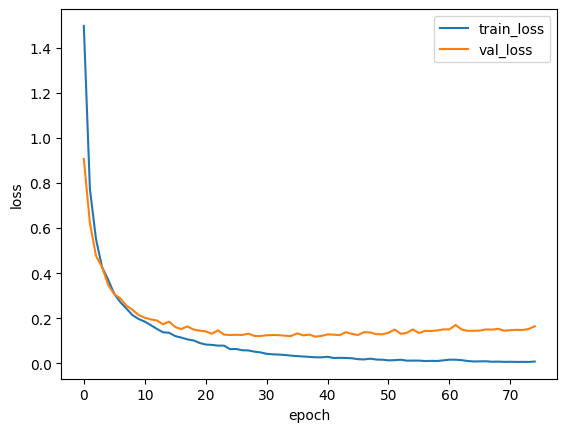

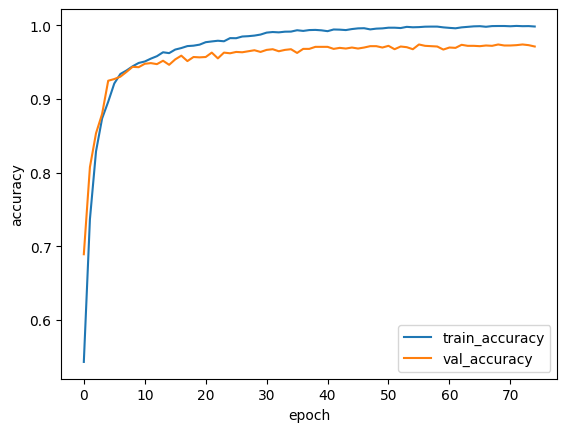

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

# Model Load and predict

In [22]:
epoch = 30
checkpoint_path = f"./model/malware_cnn32/model_{epoch}.ckpt"

malware_class = Simple_CNN()
malware_class.load_weights(checkpoint_path)
malware_class.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 50)      1300      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 50)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 70)        31570     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 70)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 70)        44170     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 70)      

In [25]:
loss, acc = malware_class.evaluate(val_dataset, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

9/9 [==============================] - 1s 42ms/step - loss: 0.1206 - accuracy: 0.9637
Restored model, accuracy: 96.37%


In [42]:
imgs = glob("./dataset/img/img128/*.png")
img = tf.io.read_file(imgs[0])
img = tf.io.decode_image(img)
img = tf.expand_dims(img,axis=0)
img.shape

TensorShape([1, 128, 128, 1])

In [43]:
prediction= malware_class.predict(img)
prediction

1/1 [==============================] - 0s 14ms/step


array([[0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)